# 3. Community Detection

We perform community detection on our graph of replies.

**Table of contents:**
- Community detection
    1. Greedy modularity
    2. Louvain
    3. FluidC
    4. Infomap
- Community detection in separated time windows

In [ ]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import networkx as nx
from infomap import Infomap

# load
df_ending = pd.read_csv('../data/aot_ending.csv')
df_ending['created_utc'] = pd.to_datetime(df_ending['created_utc'])
df_comments = pd.read_csv('../data/comments_graph_ending_final.csv')
df_comments['created_utc'] = pd.to_datetime(df_comments['created_utc'])
G = pickle.load(open('../data/comments_graph.pickle', 'rb'))

## Community detection

Measures that we can compute to assess the quality of the partition of the graph. Are a function of the graph `G` and a `partition` of such graph (list of sets, where each set is a community).

- **Modularity**:   
  $$Q = \frac{1}{2m} \sum_{ij} \left( A_{ij} - \gamma \frac{k_i k_j}{2m} \right) \delta(c_i, c_j)$$  
    where $m$ is the number of edges, $A$ is the adjacency matrix of `G`, $k_i$ is the (weighted) degree of $i$ (1 in our case), $\gamma$ is the resolution parameter, and $\delta(c_i, c_j)$ is 1 if $i$ and $j$ are in the same community else 0.

- **Coverage**:  
  $$\text{Coverage} = \frac{\text{intra-community edges}}{\text{total edges in the graph}}$$  
  It rewards the absence of edges between communities - so it will prefer separating small clusters from the hubs.

- **Perforance**:  
  $$\text{Performance} = \frac{\text{intra-community edges} + \text{inter-community non-edges}}{\text{total possible edges}}$$  
  measure how well-separated the communities are. It rewards both dense connections within communities and sparse connections between communities.

In [42]:
def community_detection(G, c):
    """Community detection utility function"""
    # number of communities
    print("Number of communities: ", len(c), end="\n\n")

    # size of communities
    community_sizes = [len(community) for community in c]
    for i, size in enumerate(community_sizes, 1):
        print(f"Community {i:>2}: Size {size}")

    # modularity
    modularity = nx.community.modularity(G, c)
    coverage, performance = nx.community.partition_quality(G, c)
    print(f"\nModularity: {modularity:.4f}")
    print(f"Coverage: {coverage:.4f}, Performance: {performance:.4f}\n")
    metrics = {
        'modularity': modularity,
        'coverage': coverage,
        'performance': performance,
        'num_communities': len(c),
    }
    
    ######
    # create a DataFrame node-community
    l=[]
    i=0

    for community in c:
        for node in community:
            l.append([node,i])
        i+=1

    # create DataFrame
    # IMPORTANT: the order of nodes in the DataFrame is the same as in G.nodes()
    # so we match the communities to the nodes in the graph, for example for the color in the plot
    df = pd.DataFrame(l, columns=['node', 'community'])
    df = df.set_index('node').reindex(G.nodes()).reset_index()

    return df, metrics


In [18]:
pos = nx.spring_layout(G, iterations=50, seed=1721)


### 1. Greedy modularity

In [47]:
metrics_results = []

In [48]:
c_greedy = nx.community.greedy_modularity_communities(G)
df_greedy, metrics = community_detection(G, c_greedy)
metrics['algorithm'] = 'greedy'
metrics_results.append(metrics)

Number of communities:  157

Community  1: Size 3333
Community  2: Size 1103
Community  3: Size 831
Community  4: Size 827
Community  5: Size 728
Community  6: Size 441
Community  7: Size 295
Community  8: Size 264
Community  9: Size 242
Community 10: Size 193
Community 11: Size 164
Community 12: Size 113
Community 13: Size 112
Community 14: Size 109
Community 15: Size 105
Community 16: Size 89
Community 17: Size 82
Community 18: Size 57
Community 19: Size 49
Community 20: Size 43
Community 21: Size 37
Community 22: Size 19
Community 23: Size 18
Community 24: Size 17
Community 25: Size 15
Community 26: Size 15
Community 27: Size 13
Community 28: Size 13
Community 29: Size 13
Community 30: Size 12
Community 31: Size 12
Community 32: Size 12
Community 33: Size 10
Community 34: Size 9
Community 35: Size 9
Community 36: Size 8
Community 37: Size 7
Community 38: Size 7
Community 39: Size 6
Community 40: Size 6
Community 41: Size 5
Community 42: Size 5
Community 43: Size 5
Community 44: Size

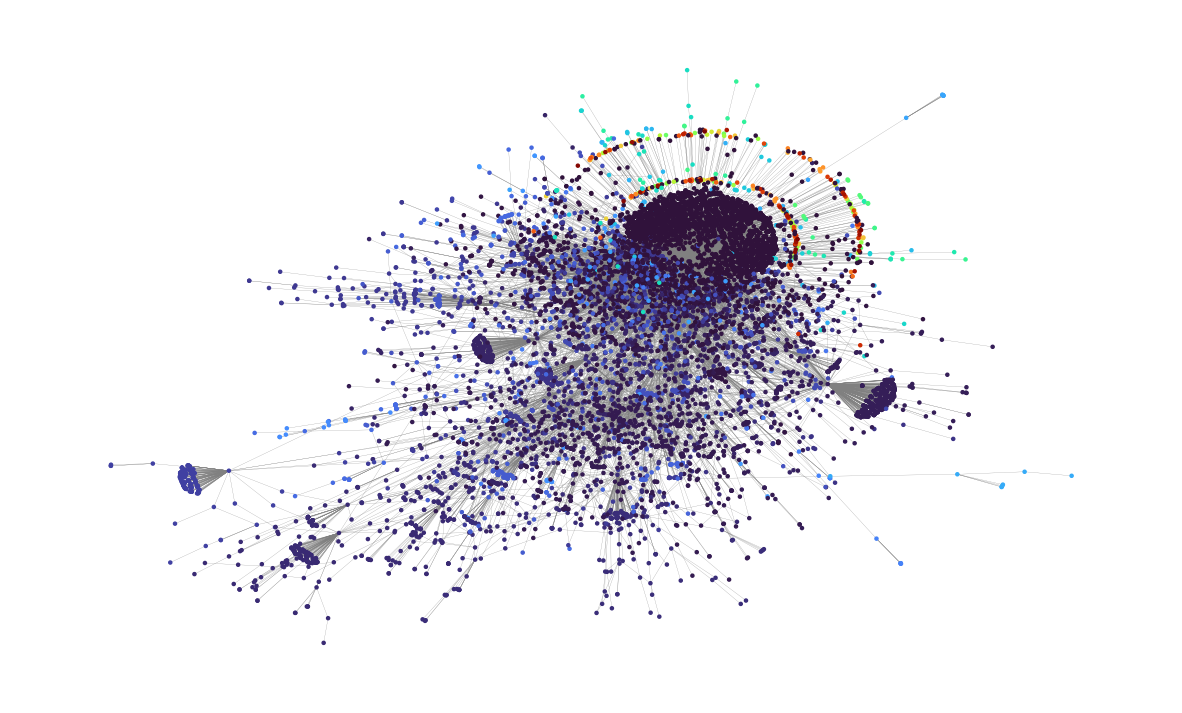

In [49]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, node_color=df_greedy['community'], cmap=plt.cm.turbo, edge_color='gray', node_size=5, with_labels=False, width=0.15)

### 2. Louvain

In [50]:
c_louvain = nx.community.louvain_communities(G)
df_louvain, metrics = community_detection(G, c_louvain)
metrics['algorithm'] = 'louvain'
metrics_results.append(metrics)

Number of communities:  55

Community  1: Size 183
Community  2: Size 329
Community  3: Size 82
Community  4: Size 253
Community  5: Size 158
Community  6: Size 234
Community  7: Size 214
Community  8: Size 358
Community  9: Size 2937
Community 10: Size 228
Community 11: Size 68
Community 12: Size 3
Community 13: Size 421
Community 14: Size 545
Community 15: Size 116
Community 16: Size 3
Community 17: Size 63
Community 18: Size 4
Community 19: Size 173
Community 20: Size 3
Community 21: Size 869
Community 22: Size 3
Community 23: Size 3
Community 24: Size 349
Community 25: Size 5
Community 26: Size 59
Community 27: Size 3
Community 28: Size 3
Community 29: Size 86
Community 30: Size 27
Community 31: Size 9
Community 32: Size 4
Community 33: Size 69
Community 34: Size 73
Community 35: Size 105
Community 36: Size 85
Community 37: Size 3
Community 38: Size 7
Community 39: Size 195
Community 40: Size 3
Community 41: Size 4
Community 42: Size 78
Community 43: Size 3
Community 44: Size 3
Com

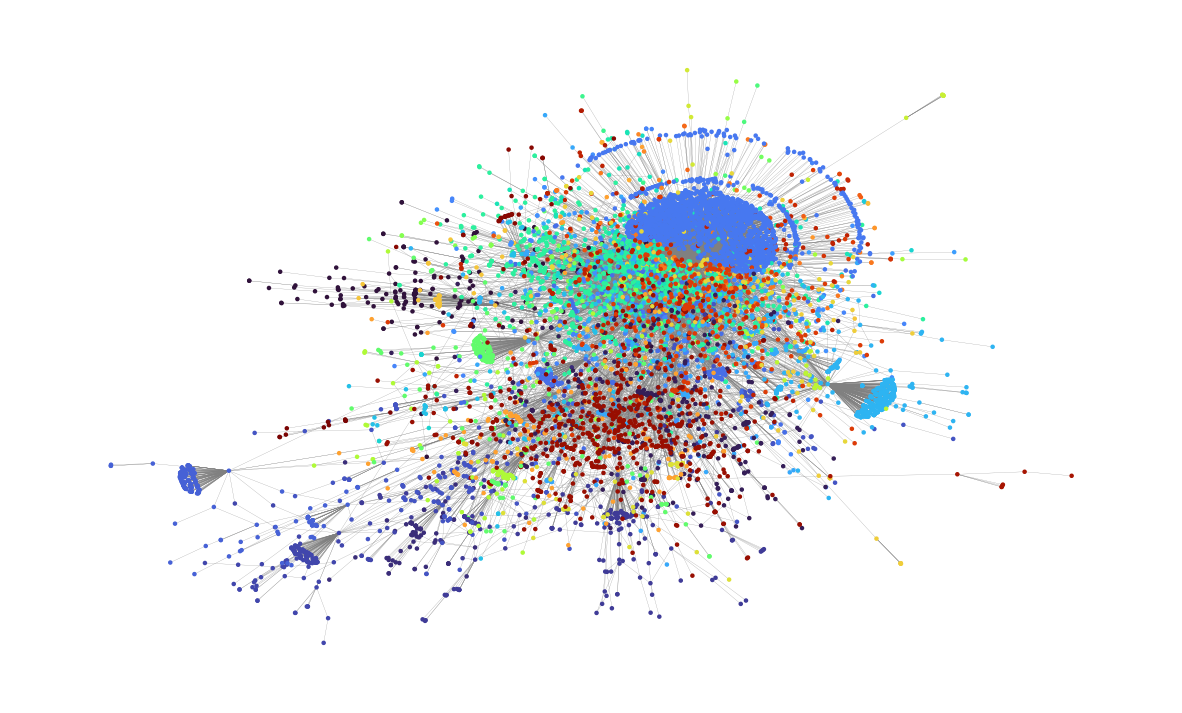

In [51]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, node_color=df_louvain['community'], cmap=plt.cm.turbo, edge_color='gray', node_size=5, with_labels=False, width=0.15)

### 3. FluidC

In [52]:
k_to_modularity = {}
for k in range(1, 26):
    c = list(nx.community.asyn_fluidc(G, k))
    modularity = nx.community.modularity(G, c)
    k_to_modularity[k] = modularity
    print(f"#communities = {k}, Modularity = {modularity:.4f}")

#communities = 1, Modularity = 0.0000
#communities = 2, Modularity = 0.3304
#communities = 3, Modularity = 0.4991
#communities = 4, Modularity = 0.4685
#communities = 5, Modularity = 0.5422
#communities = 6, Modularity = 0.4575
#communities = 7, Modularity = 0.5225
#communities = 8, Modularity = 0.6366
#communities = 9, Modularity = 0.5272
#communities = 10, Modularity = 0.5594
#communities = 11, Modularity = 0.4948
#communities = 12, Modularity = 0.5351
#communities = 13, Modularity = 0.5319
#communities = 14, Modularity = 0.4909
#communities = 15, Modularity = 0.5192
#communities = 16, Modularity = 0.4978
#communities = 17, Modularity = 0.5720
#communities = 18, Modularity = 0.5190
#communities = 19, Modularity = 0.4990
#communities = 20, Modularity = 0.5220
#communities = 21, Modularity = 0.5181
#communities = 22, Modularity = 0.5021
#communities = 23, Modularity = 0.4959
#communities = 24, Modularity = 0.5022
#communities = 25, Modularity = 0.5031


In [53]:
# the best k is the one with the highest modularity
top_k = max(k_to_modularity, key=k_to_modularity.get)
c_fluidc = list(nx.community.asyn_fluidc(G, k=top_k))
df_fluidc, metrics = community_detection(G, c_fluidc)
metrics['algorithm'] = 'fluidc'
metrics_results.append(metrics)

Number of communities:  8

Community  1: Size 1394
Community  2: Size 780
Community  3: Size 643
Community  4: Size 816
Community  5: Size 793
Community  6: Size 3413
Community  7: Size 974
Community  8: Size 906

Modularity: 0.6269
Coverage: 0.7981, Performance: 0.8131



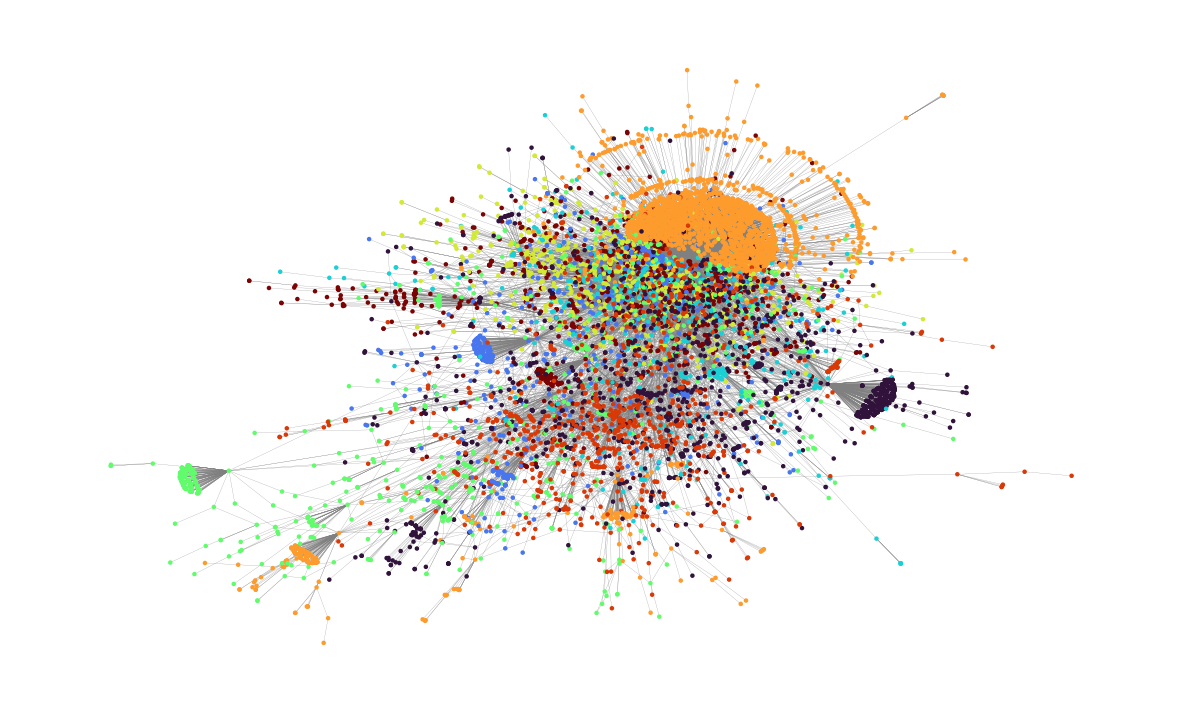

In [54]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, node_color=df_fluidc['community'], cmap=plt.cm.turbo, edge_color='gray', node_size=5, with_labels=False, width=0.15)

We tried also Fluidc for showing that it is not suited when we have a big difference in size between divisive subgroups. This is given from his nature as an algorithm, since to each community is given a the same limited amount of resources.

### 4. Infomap

In [55]:
# run infomap
im = Infomap(silent=True, seed=42)
id_to_node = im.add_networkx_graph(G)
node_to_id = {node: i for i, node in id_to_node.items()}
im.run()

partition = {id_to_node[node.node_id]: node.module_id for node in im.iterLeafNodes()}

# Print a small subset of the mappings and partition
print("id_to_node (sample) :", dict(list(id_to_node.items())[:5])) # infomap ids to node names
print("node_to_id (sample) :", dict(list(node_to_id.items())[:5])) # node names to infomap ids
print("partition  (sample) :", dict(list(partition.items())[:5]))  # node names to community ids

id_to_node (sample) : {0: 'joaopaulofoo', 1: 'Umer123321', 2: 'ashai1994', 3: 'Jdep11', 4: 'LordNelson27'}
node_to_id (sample) : {'joaopaulofoo': 0, 'Umer123321': 1, 'ashai1994': 2, 'Jdep11': 3, 'LordNelson27': 4}
partition  (sample) : {'Sane-Ni-Wa-To-Ri': 1, 'soberstepdad777': 1, 'slimyRaccoon7h7': 1, 'kaitepop96': 1, 'fella_mcflips': 1}


In [ ]:
# Convert partition dictionary to communities list format for community_detection function
c_infomap = []
partition_values = set(partition.values())

for community_id in sorted(partition_values):
    community_nodes = [node for node, comm_id in partition.items() if comm_id == community_id]
    c_infomap.append(community_nodes)

df_infomap, metrics = community_detection(G, c_infomap)
metrics['algorithm'] = 'infomap'
metrics_results.append(metrics)

Number of communities:  15

Community  1: Size 5971
Community  2: Size 835
Community  3: Size 656
Community  4: Size 359
Community  5: Size 410
Community  6: Size 330
Community  7: Size 281
Community  8: Size 170
Community  9: Size 191
Community 10: Size 177
Community 11: Size 83
Community 12: Size 85
Community 13: Size 79
Community 14: Size 61
Community 15: Size 31

Modularity: 0.5278
Coverage: 0.9342, Performance: 0.6045



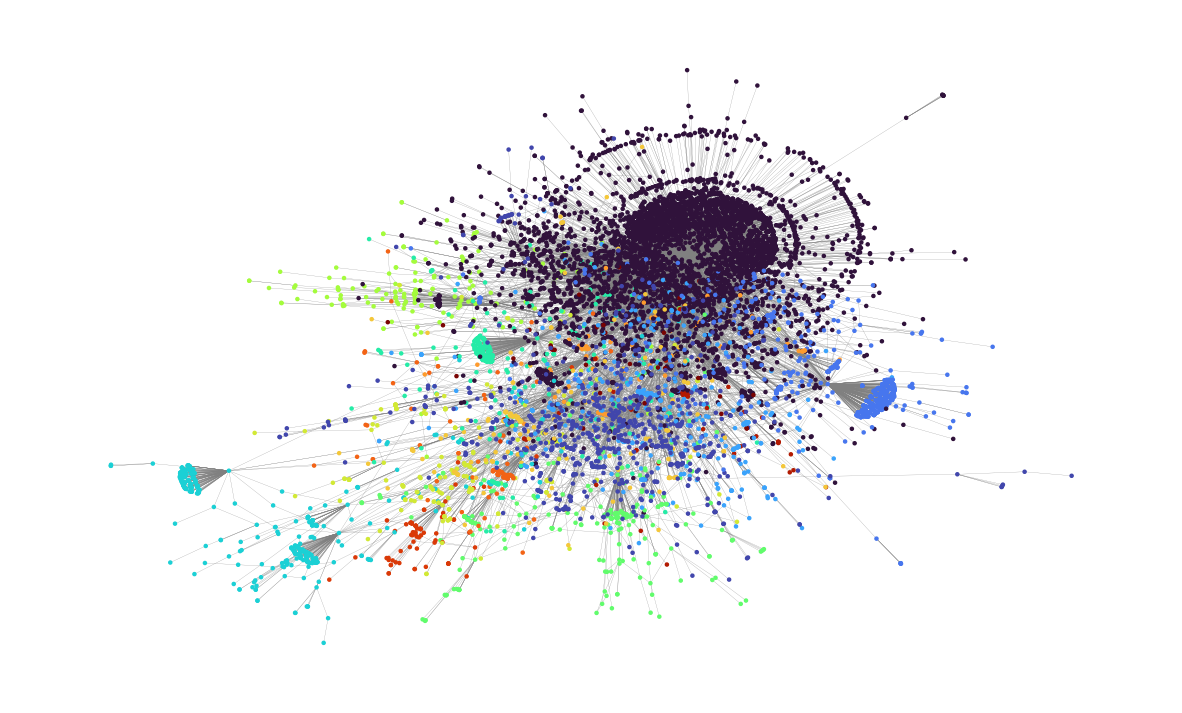

In [57]:
node_color = [partition[node] for node in G.nodes()]

fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, node_color=node_color, cmap=plt.cm.turbo, edge_color='gray', node_size=5, with_labels=False, width=0.15)

### Results

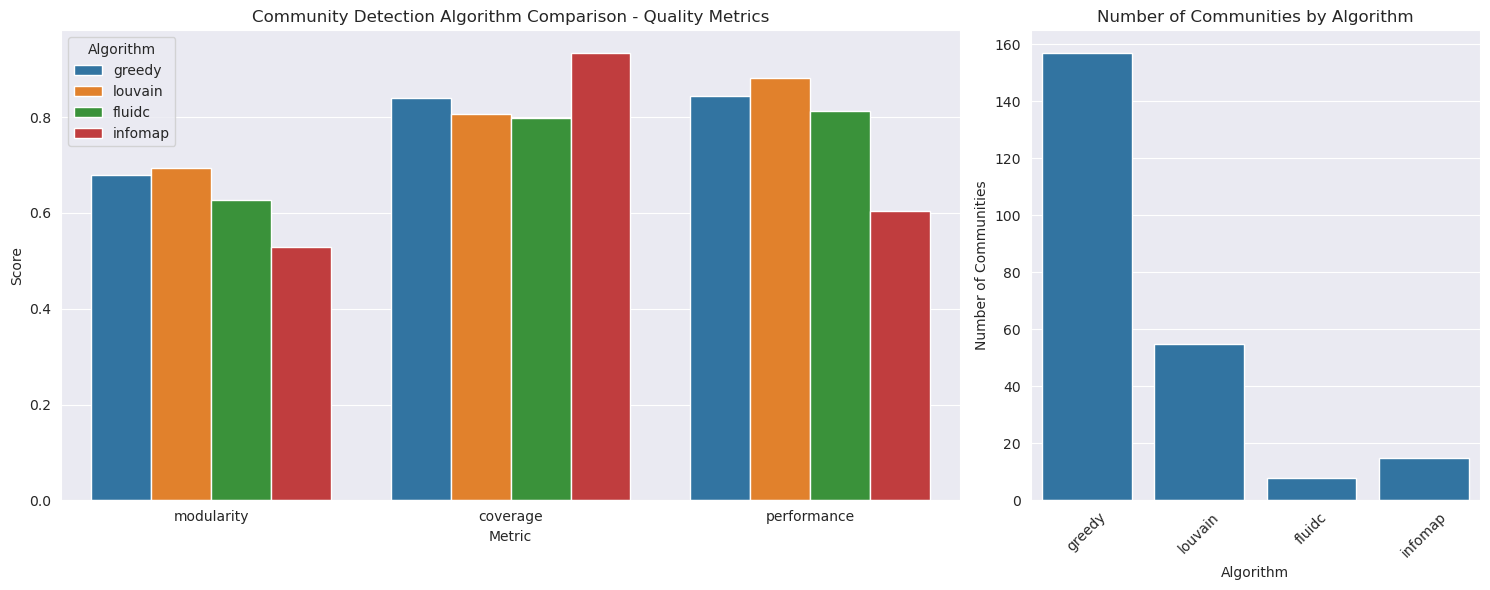

In [75]:
from matplotlib import gridspec
df_metrics = pd.DataFrame(metrics_results)
df_metrics_melted = df_metrics.melt(id_vars=['algorithm'], 
                                   value_vars=['modularity', 'coverage', 'performance'], 
                                   var_name='metric', 
                                   value_name='score')

fig = plt.figure(figsize=(15, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

# Modularity, Coverage, Performance
df_metrics_subset = df_metrics_melted[df_metrics_melted['metric'].isin(['modularity', 'coverage', 'performance'])]
sns.barplot(data=df_metrics_subset, x='metric', y='score', hue='algorithm', ax=ax1)
ax1.set_title('Community Detection Algorithm Comparison - Quality Metrics')
ax1.set_xlabel('Metric')
ax1.set_ylabel('Score')
ax1.legend(title='Algorithm')

# Number of communities
sns.barplot(data=df_metrics, x='algorithm', y='num_communities', ax=ax2)
ax2.set_title('Number of Communities by Algorithm')
ax2.set_xlabel('Algorithm')
ax2.set_ylabel('Number of Communities')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

We chose the Infomap method as since it provides much higher ***coverage***, which gives us better separation between clusters. Another advantage is the number of communities it finds (15), compared to the 55 found by Louvain. 

Having a smaller number of communities is more reasonable for such a focused dataset. We can see that, in Louvain, around 20 communities have fewer than 10 members, all centred around the *Sane-Ni-Wa-To-Ri hub*. In contrast, the Infomap algorithm aggregates them into this big hub, which we find more reasonable than having so many smaller communities.

With Girvan-Newman is very complex to compute the specific partitions of the graphs, since it can be very slow with big graphs, we didn't use it.

Store in a dataframe all the communities

In [29]:
df_fluidc.rename(columns={'community': 'fluidc_community'}, inplace=True)
df_louvain.rename(columns={'community': 'louvain_community'}, inplace=True)
df_greedy.rename(columns={'community': 'greedy_community'}, inplace=True)
df_infomap.rename(columns={'community': 'infomap_community'}, inplace=True)
# merge the DataFrames
df_communities = df_fluidc.merge(df_louvain, on='node').merge(df_greedy, on='node').merge(df_infomap, on='node')
# save the DataFrame
df_communities.to_csv('../data/communities.csv', index=False)
df_communities.head()

,node,fluidc_community,louvain_community,greedy_community,infomap_community
0,joaopaulofoo,0,22,8,6
1,Umer123321,0,22,8,6
2,ashai1994,0,22,8,6
3,Jdep11,0,22,8,6
4,LordNelson27,0,22,8,6



---

## Community detection in separated time windows



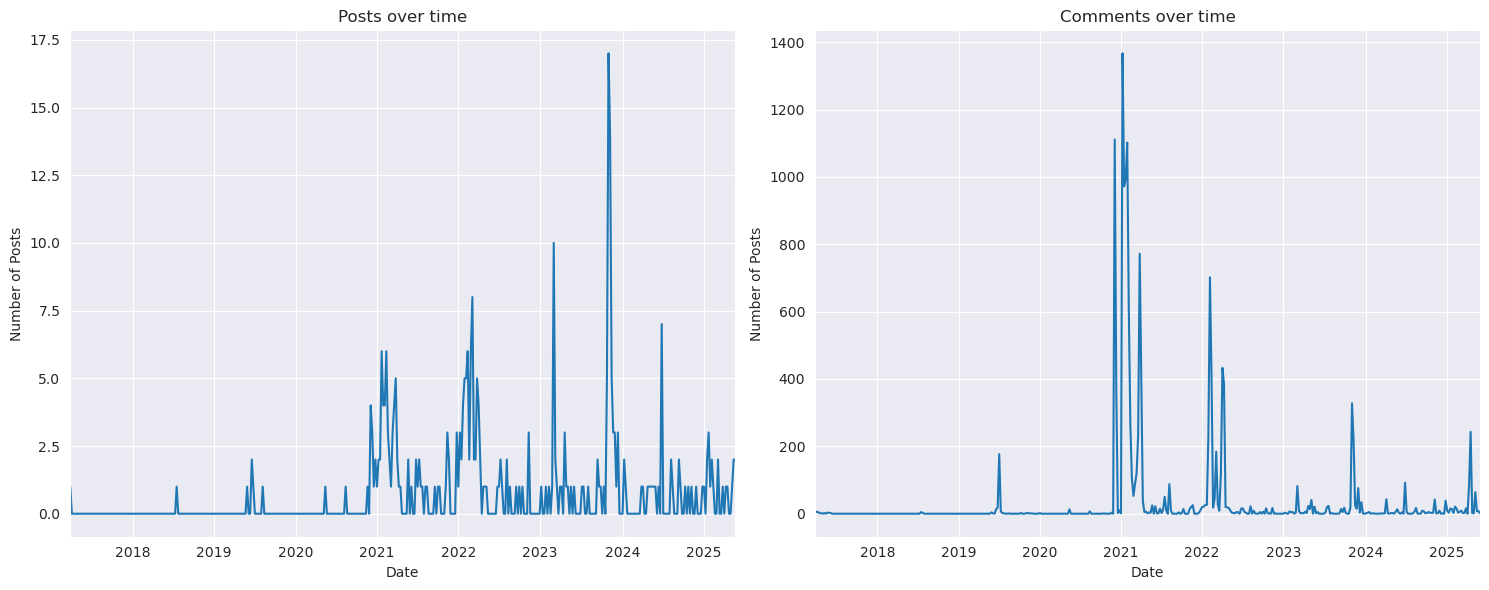

In [76]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# W stands for Week
df_ending.set_index('created_utc').resample('W').size().plot(ax=axes[0], title="Posts over time")
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Number of Posts')

df_comments.set_index('created_utc').resample('W').size().plot(ax=axes[1], title="Comments over time")
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Number of Posts')

plt.tight_layout()
plt.show()

The number of posts over time doesn't quite match the comments over time, It means that we don't have many submissions around the 2021, but this submsission have really a lot of comments. And in 2021 ended the manga, so the story of AoT.

We analyse the subgraph depending on a specific time window. With work of this kind, the time period has a significant influence on the topics people talk about. People's feelings also change. We specify the following 3 windows:
1. from 2020-06-30 to 2021-06-30
2. from 2021-06-30 to 2022-06-30
3. from 2022-06-30 till now

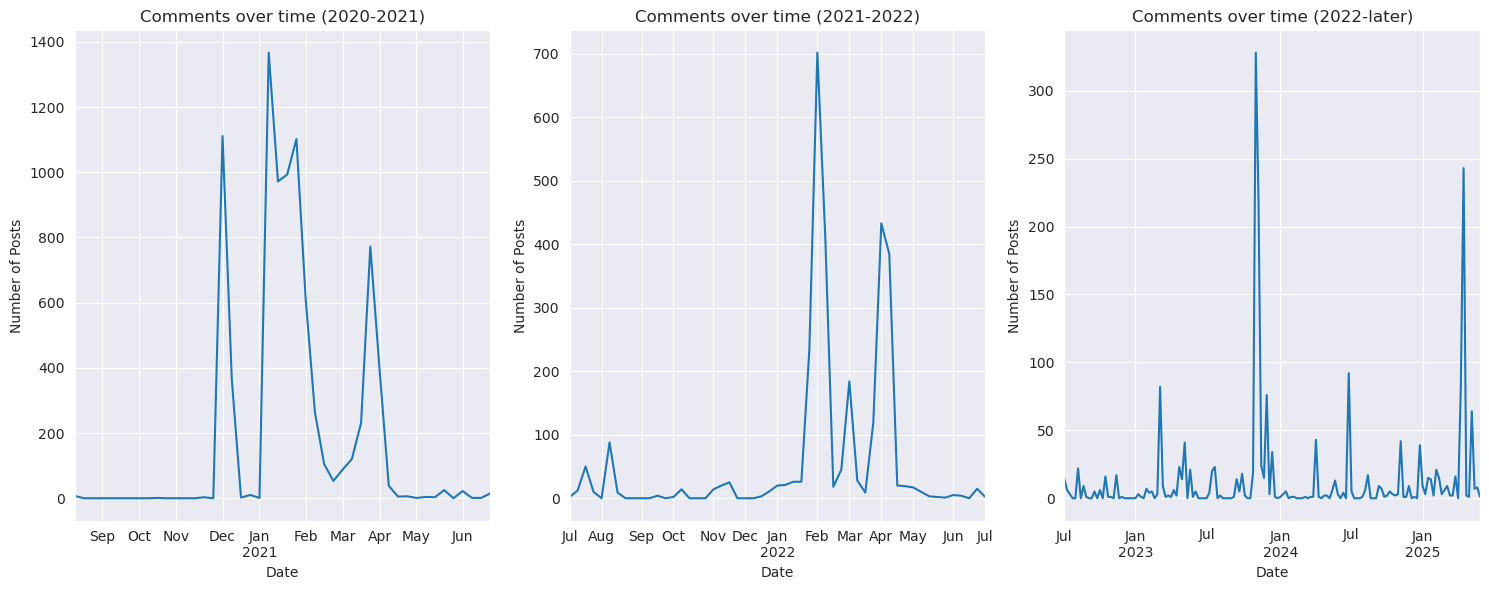

In [84]:
# Define the date ranges
mid_2020 = pd.Timestamp('2020-06-30')
mid_2021 = pd.Timestamp('2021-06-30')
mid_2022 = pd.Timestamp('2022-06-30')

# Filter the DataFrame into three sub-DataFrames
df_comments_2020_2021 = df_comments[(df_comments['created_utc'] > mid_2020) & (df_comments['created_utc'] <= mid_2021)]
df_comments_2021_2022 = df_comments[(df_comments['created_utc'] > mid_2021) & (df_comments['created_utc'] <= mid_2022)]
df_comments_later = df_comments[df_comments['created_utc'] > mid_2022]

fig, axes = plt.subplots(1, 3, figsize=(15, 6))

df_comments_2020_2021.set_index('created_utc').resample('W').size().plot(ax=axes[0], title="Comments over time (2020-2021)")
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Number of Posts')

df_comments_2021_2022.set_index('created_utc').resample('W').size().plot(ax=axes[1], title="Comments over time (2021-2022)")
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Number of Posts')

df_comments_later.set_index('created_utc').resample('W').size().plot(ax=axes[2], title="Comments over time (2022-later)")
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Number of Posts')

plt.tight_layout()
plt.show()

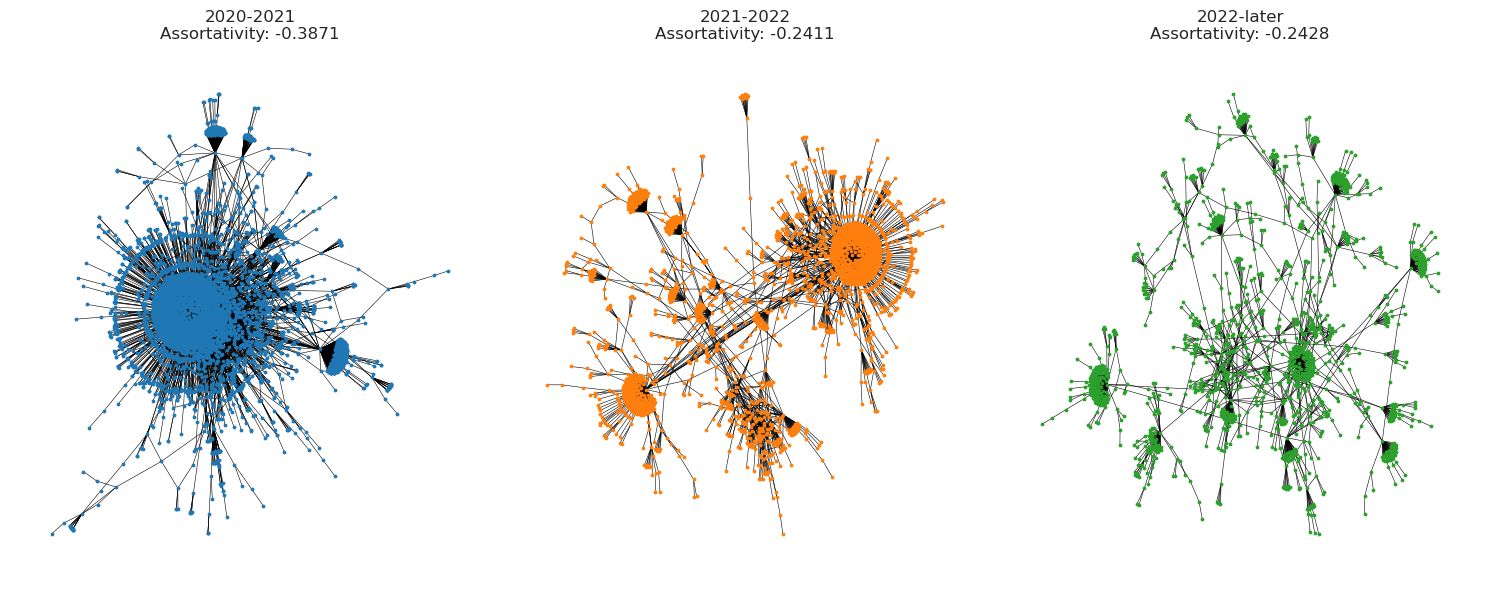

In [ ]:
def build_graph(df):
    """Build a graph from the DataFrame, removing self-loops and keeping only the largest connected component."""
    G = nx.Graph()
    for _, r in df.iterrows():
        G.add_edge(r['parent'], r['child'])


    G.remove_edges_from(list(nx.selfloop_edges(G)))
    largest_cc = max(nx.connected_components(G), key=len)
    G = G.subgraph(largest_cc).copy()
    return G

# Build graphs for each time period
Gs = [
    build_graph(df_comments_2020_2021), 
    build_graph(df_comments_2021_2022), 
    build_graph(df_comments_later)
]
titles = ['2020-2021', '2021-2022', '2022-later']
poss = [nx.spring_layout(G, iterations=50, seed=1721) for G in Gs]

# show the graphs
cmap = plt.cm.tab10
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
for i in range(3):
    assortativity = nx.degree_assortativity_coefficient(Gs[i])
    ax = axes[i]
    ax.axis("off")
    nx.draw_networkx(
        Gs[i], pos=poss[i], ax=ax,
        node_color=[cmap(i)],  # muted color for each graph
        edge_color='black',
        node_size=3,
        with_labels=False,
        width=0.4,
    )
    ax.set_title(titles[i]+f"\nAssortativity: {assortativity:.4f}")
plt.tight_layout()
plt.show()
  

Now we run infomap on the 3 subgraphs.

In [93]:
def community_detection_quite(G, c):
    """Community detection utility function - more quiet version"""
    community_sizes = sorted([len(community) for community in c], reverse=True)
    modularity = nx.community.modularity(G, c)
    coverage, performance = nx.community.partition_quality(G, c)

    print(f"# communities = {len(c)}\nsizes : {', '.join(map(str, community_sizes))}")
    print(f"Modularity = {modularity:.4f}, Coverage: {coverage:.4f}, Performance: {performance:.4f}")

    # create a DataFrame node-community
    l = []
    i = 0

    for community in c:
        for node in community:
            l.append([node,i])
        i += 1

    # create DataFrame
    df = pd.DataFrame(l, columns=['node', 'community'])
    df = df.set_index('node').reindex(G.nodes()).reset_index()

    return df

def run_infomap(G):
    # Convert partition dictionary to communities list format for community_detection function
    # run infomap
    im = Infomap(silent=True, seed=42)
    id_to_node = im.add_networkx_graph(G)
    im.run()
    partition = {id_to_node[node.node_id]: node.module_id for node in im.iterLeafNodes()}

    c_infomap = []
    partition_values = set(partition.values())
    for community_id in sorted(partition_values):
        community_nodes = [node for node, comm_id in partition.items() if comm_id == community_id]
        c_infomap.append(community_nodes)
    return c_infomap


communities = []
for i in range(0, 3):
    print(titles[i])
    c_infomap = run_infomap(Gs[i])
    df_infomap = community_detection_quite(Gs[i], c_infomap)
    communities.append(df_infomap)
    print("=" * 50 + "\n")

2020-2021
# communities = 8
sizes : 4654, 437, 192, 165, 67, 49, 47, 18
Modularity = 0.2718, Coverage: 0.9785, Performance: 0.3085

2021-2022
# communities = 2
sizes : 1703, 543
Modularity = 0.3917, Coverage: 0.9985, Performance: 0.3678

2022-later
# communities = 12
sizes : 347, 175, 151, 133, 98, 96, 90, 80, 65, 55, 29, 27
Modularity = 0.8391, Coverage: 0.9765, Performance: 0.8732



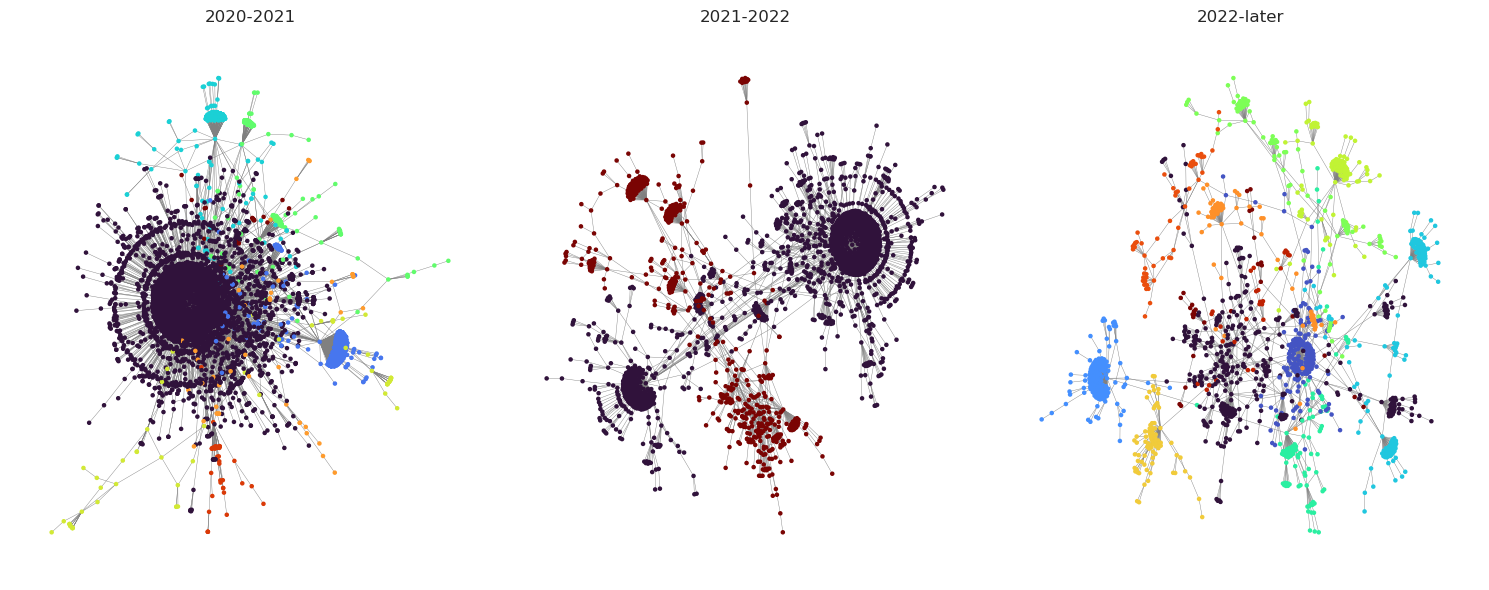

In [94]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
for i in range(3):
    ax = axes[i]
    ax.axis("off")
    nx.draw_networkx(
        Gs[i], pos=poss[i], ax=ax,
        node_color=communities[i]['community'],
        cmap=plt.cm.turbo,
        edge_color='gray',
        node_size=5,
        with_labels=False,
        width=0.3,
    )
    ax.set_title(titles[i])
plt.tight_layout()
plt.show()